# MLP

# 0. Setup: load modules and define functions

In [2]:
# Import packages

# Read and prepare dataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# For model training
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_predict
from numpy.random import randint
import random

# For model evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Save and load model
from joblib import dump, load

In [4]:
# For loading and preprocessing data
def prepare_data(csv):
    """
    Read csv and returns: 
    X_train: full no-oversampled features, 
    y_train: no-oversampled labels, 
    X_train_os: full oversampled features, 
    y_train_os: oversampled features, 
    X_train_os_sub: selected, oversampled, standardized features, 
    y_train_os_sub: oversampled features, same as y_train_os, just for easier use.
    """
    # 1.Read data
    train_df = pd.read_csv(csv)

    # 2. Split X, y
    X = train_df.iloc[:, :12]
    y_train = train_df.iloc[:, 12]

    # 3. Perform feature scaling
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X)
    
    # 4. SMOTE
    smote = SMOTE(sampling_strategy='minority', random_state=66)
    X_train_os, y_train_os = smote.fit_resample(X, y_train)
    scaler = StandardScaler()
    X_train_os = scaler.fit_transform(X_train_os)
    
    # 5. Feature Selection
    X_train_os_sub, y_train_os_sub = smote.fit_resample(train_df.iloc[:, [0,1,2,3,4,6,7,10,11]], 
                                                train_df.iloc[:, 12])
    X_train_os_sub = scaler.fit_transform(X_train_os_sub)
    
    return X_train, y_train, X_train_os, y_train_os, X_train_os_sub, y_train_os_sub

# ref: https://www.datacamp.com/blog/classification-machine-learning

In [5]:
# For fitting and evaluating MLP
# the "default" hyperparameter is from pair coursework
def train_MLP(X, y, hidden_layer_sizes, lr=0.1, momentum=0, activation='logistic'):
    """
    X: features, e.g. X_train
    y: labels, e.g. y_train(no need to one-hot encoding)
    hidden_layer_sizes: e.g.(8,8,6)
    """
    MLP = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, 
                        activation=activation,
                        solver='sgd',
                        learning_rate_init = lr,
                        early_stopping=True,
                        random_state=431, 
                        max_iter=200,
                        warm_start=True,
                        momentum=momentum)
    T0 = time.time()
    y_pred_cv = cross_val_predict(MLP, X, y, cv=5)
    T1 = time.time()
    training_time = T1-T0
    
    # Calculate and display results
    acc = accuracy_score(y, y_pred_cv)
    cm = confusion_matrix(y, y_pred_cv)
    print(f"Acc: {acc:.4f}")
    print(f"Training Time: {training_time:.4f}")
    print("Evaluation with cross-validation")
    print("\nClassification Report:")
    print(classification_report(y, y_pred_cv))
    plt.figure(figsize=(3, 3))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('CM')
    plt.show()
    
    return MLP, acc, training_time

# Ref: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier

In [25]:
# For random search tuning
def tune_MLP(X, y, layer):
    """
    X: features,e.g. X_train
    y: labels, e.g. y_train
    layer: 1, 2, 3 """

    # Create MLP model
    MLP = MLPClassifier(
        random_state=431, 
        early_stopping=True,
        verbose=0,
        max_iter=300
    )
    
    # Define hyperparameter grid for sgd 
    layer_1 = (randint(10, 90),)
    layer_2 = (randint(10, 90), randint(10, 90))
    layer_3 = (randint(10, 90), randint(10, 90), randint(10, 90))
    
    if layer == 1:
        layer = layer_1
    elif layer == 2:
        layer = layer_2
    elif layer == 3:
        layer = layer_3

    param_dist_sgd = {
        'hidden_layer_sizes': [layer],
#         'solver': ['sgd', 'adam'],
        'solver': ['sgd'],
        'activation': ['relu', 'tanh', 'logistic'],
        'learning_rate_init': [random.uniform(0.001, 0.1) for _ in range(100)],
        'alpha': [0.0001, 0.001],
        'momentum': [random.uniform(0.9, 0.99) for _ in range(100)]
    }

    # Create RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=MLP,
        param_distributions=param_dist_sgd,
        n_iter=15,  
        cv=5,  
        scoring='accuracy',  
#         random_state=431,
        verbose=0,
        n_jobs=-1
    )

    # Perform random search
    T0 = time.time()
    random_search.fit(X, y)
    T1 = time.time()
    training_time = T1-T0

    # Check the best model and the best params
    best_estimator = random_search.best_estimator_
    best_params = random_search.best_params_
    best_score = random_search.best_score_
    print(f"Best Parameters: {best_params}")
    print(f"Best Acc Score: {best_score:.4f}")
    print(f"Training time: {training_time:.4f}")
    
    # Check performance
    y_pred_cv = cross_val_predict(best_estimator, X, y, cv=5)
    print("\nClassification Report:")
    print(classification_report(y, y_pred_cv))

    # Plot confusion matrix
    cm = confusion_matrix(y, y_pred_cv)
    plt.figure(figsize=(3, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('CM')
    plt.show()

    return best_estimator, best_score, training_time, best_params

In [35]:
# For testing on test set
def final_test(csv, model):
    """
    Test model on unseen test set.
    """
    # 1. Read and prepare unseen test set
    unseen_df = pd.read_csv(csv)
    X_unseen = unseen_df.iloc[:, :12]
    y_unseen = unseen_df.iloc[:, 12]

    scaler = StandardScaler()
    X_unseen = scaler.fit_transform(X_unseen)

    # 2. Load model
    model = load(model)
    
    # 3. Predict and evaluate on unseen TEST set
    y_preds_test = model.predict(X_unseen)
    cm_test = confusion_matrix(y_unseen, y_preds_test)

    # 4. Display test results
    print("Classification Report on Test Set")
    print(classification_report(y_unseen, y_preds_test))
    # print(f"Acc: {acc_test}, Precision: {precision_test}, Recall: {recall_test}")
    plt.figure(figsize=(3, 3))
    sns.heatmap(cm_test, annot=True, cmap='Blues', fmt='d', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('CM on test set')
    plt.show()

# 1. Read and prepare data sets

In [6]:
X_train, y_train, X_train_os, y_train_os, X_train_os_sub, y_train_os_sub = prepare_data('train.csv')


# 2. Training

### 2.1. Train baseline MLP with 1-hidden-layer

Acc: 0.5688
Training Time: 2.1346
Evaluation with cross-validation

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.65      0.64      1907
           1       0.53      0.63      0.57      2269
           2       0.55      0.29      0.38      1021

    accuracy                           0.57      5197
   macro avg       0.57      0.52      0.53      5197
weighted avg       0.57      0.57      0.56      5197



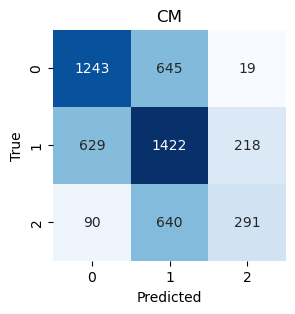

In [7]:
# Fit baseline model
MLP_baseline, acc_base,training_time_base = train_MLP(X_train, y_train, (10,))

### 2.2. Experiments: Try oversampling and Feature Selection on top of baseline
as input-level tuning

#### 2.2.1. Try SMOTE oversampling on top of baseline

Acc: 0.5657
Training Time: 1.6728
Evaluation with cross-validation

Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.63      0.60      1907
           1       0.47      0.34      0.39      2269
           2       0.62      0.74      0.67      2269

    accuracy                           0.57      6445
   macro avg       0.55      0.57      0.56      6445
weighted avg       0.55      0.57      0.55      6445



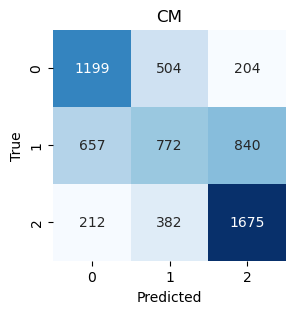

In [8]:
# Fit and evaluate MLP with oversampled training set
MLP_OS, acc_OS,training_time_OS = train_MLP(X_train_os, y_train_os, (10,))

#### 2.2.2. Try Feature selection on top of SMOTE

Acc: 0.5694
Training Time: 1.9621
Evaluation with cross-validation

Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.67      0.63      1907
           1       0.48      0.32      0.38      2269
           2       0.60      0.74      0.66      2269

    accuracy                           0.57      6445
   macro avg       0.56      0.57      0.56      6445
weighted avg       0.56      0.57      0.55      6445



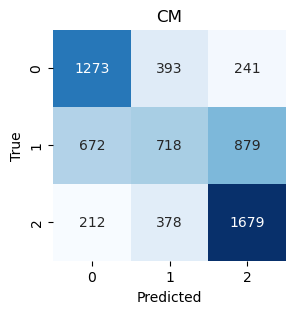

In [9]:
# Fit and evaluate MLP with oversampled and feature selection training set
MLP_sub, acc_sub,training_time_sub = train_MLP(X_train_os_sub, y_train_os_sub, (10,))

# 3. Hyperparameter tuning (with random search)
hyperparameters:
* number of hidden layers
* number of hidden neurons
* initial learning rate
* weight decay
* activation function

In [7]:
# Define lists to store intermediate models, performance and training_time
model_names = []
models = []
accs = []
training_times = []
best_params = []

## 3.1. One hidden layer * Three types of inputs

Best Parameters: {'solver': 'sgd', 'momentum': 0.9688715925972016, 'learning_rate_init': 0.03528650746259974, 'hidden_layer_sizes': (16,), 'alpha': 0.0001, 'activation': 'relu'}
Best Acc Score: 0.5996
Training time: 7.0662

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.68      0.67      1907
           1       0.55      0.62      0.59      2269
           2       0.58      0.39      0.47      1021

    accuracy                           0.60      5197
   macro avg       0.60      0.57      0.58      5197
weighted avg       0.60      0.60      0.60      5197



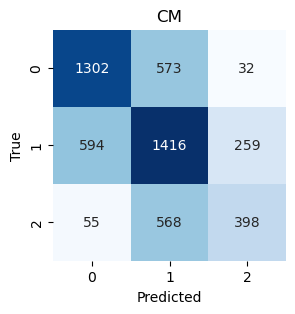

In [12]:
# Without OS, without Feature selection
best_model_1l, best_score_1l, training_time_1l, best_params_1l = tune_MLP(X_train, 
                                                          y_train, 
                                                          1)

model_names.append('best_model_1l')
models.append(best_model_1l)
accs.append(best_score_1l)
training_times.append(training_time_1l)
best_params.append(best_params_1l)

Best Parameters: {'solver': 'sgd', 'momentum': 0.9719179176871501, 'learning_rate_init': 0.06964211918149354, 'hidden_layer_sizes': (16,), 'alpha': 0.001, 'activation': 'logistic'}
Best Acc Score: 0.6158
Training time: 7.1840

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.69      0.67      1907
           1       0.51      0.42      0.46      2269
           2       0.67      0.75      0.71      2269

    accuracy                           0.62      6445
   macro avg       0.61      0.62      0.61      6445
weighted avg       0.61      0.62      0.61      6445



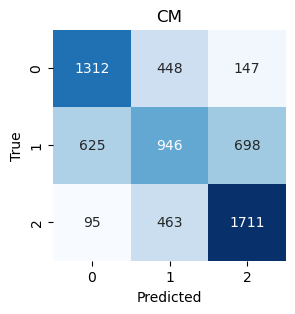

In [21]:
# With OS, Without feature selection
best_model_1l_OS, best_score_1l_OS, training_time_1l_OS, best_params_1l_OS = tune_MLP(X_train_os, 
                                                                                      y_train_os, 
                                                                                      1)

model_names.append('best_model_1l_OS')
models.append(best_model_1l_OS)
accs.append(best_score_1l_OS)
training_times.append(training_time_1l_OS)
best_params.append(best_params_1l_OS)

Best Parameters: {'solver': 'sgd', 'momentum': 0.9574105972182728, 'learning_rate_init': 0.09251916744165431, 'hidden_layer_sizes': (16,), 'alpha': 0.0001, 'activation': 'tanh'}
Best Acc Score: 0.5971
Training time: 6.2223

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.64      0.65      1907
           1       0.48      0.42      0.45      2269
           2       0.64      0.74      0.68      2269

    accuracy                           0.60      6445
   macro avg       0.59      0.60      0.59      6445
weighted avg       0.59      0.60      0.59      6445



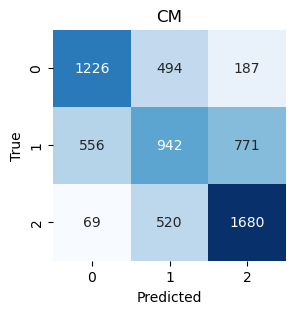

In [13]:
# With OS, With feature selection
best_model_1l_OS_sub, best_score_1l_OS_sub, training_time_1l_OS_sub, best_params_1l_OS_sub = tune_MLP(X_train_os_sub, 
                                                                                      y_train_os_sub, 
                                                                                      1)

model_names.append('best_model_1l_OS_sub')
models.append(best_model_1l_OS_sub)
accs.append(best_score_1l_OS_sub)
training_times.append(training_time_1l_OS_sub)
best_params.append(best_params_1l_OS_sub)

## 3.2. Two hidden layer * Three types of inputs

Best Parameters: {'solver': 'sgd', 'momentum': 0.9164165036676374, 'learning_rate_init': 0.06330334092629, 'hidden_layer_sizes': (60, 82), 'alpha': 0.001, 'activation': 'relu'}
Best Acc Score: 0.6102
Training time: 17.3341

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.68      0.67      1907
           1       0.57      0.62      0.59      2269
           2       0.60      0.45      0.51      1021

    accuracy                           0.61      5197
   macro avg       0.61      0.58      0.59      5197
weighted avg       0.61      0.61      0.61      5197



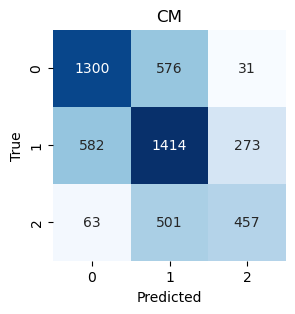

In [14]:
# Without OS, Without feature selection
best_model_2l, best_score_2l, training_time_2l, best_params_2l = tune_MLP(X_train, 
                                                                          y_train, 
                                                                          2)

model_names.append('best_model_2l')
models.append(best_model_2l)
accs.append(best_score_2l)
training_times.append(training_time_2l)
best_params.append(best_params_2l)

Best Parameters: {'solver': 'sgd', 'momentum': 0.9688851330580956, 'learning_rate_init': 0.0295067808018034, 'hidden_layer_sizes': (60, 82), 'alpha': 0.0001, 'activation': 'relu'}
Best Acc Score: 0.6641
Training time: 33.4423

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.68      0.68      1907
           1       0.58      0.48      0.52      2269
           2       0.72      0.84      0.77      2269

    accuracy                           0.66      6445
   macro avg       0.66      0.67      0.66      6445
weighted avg       0.66      0.66      0.66      6445



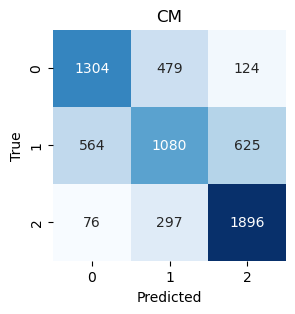

In [15]:
# With OS, Without feature selection - try multiple rounds
best_model_2l_OS, best_score_2l_OS, training_time_2l_OS, best_params_2l_OS = tune_MLP(X_train_os, 
                                                                                      y_train_os, 
                                                                                      2)

model_names.append('best_model_2l_OS')
models.append(best_model_2l_OS)
accs.append(best_score_2l_OS)
training_times.append(training_time_2l_OS)
best_params.append(best_params_2l_OS)

Best Parameters: {'solver': 'sgd', 'momentum': 0.9841212557604863, 'learning_rate_init': 0.07643609182577632, 'hidden_layer_sizes': (60, 82), 'alpha': 0.001, 'activation': 'tanh'}
Best Acc Score: 0.6295
Training time: 26.2508

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.64      0.65      1907
           1       0.53      0.49      0.51      2269
           2       0.70      0.76      0.72      2269

    accuracy                           0.63      6445
   macro avg       0.63      0.63      0.63      6445
weighted avg       0.63      0.63      0.63      6445



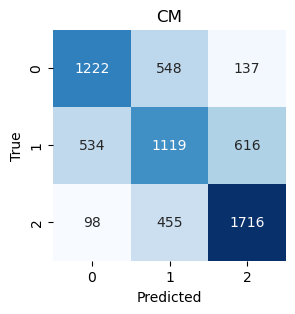

In [16]:
# With OS, With feature selection
best_model_2l_OS_sub, best_score_2l_OS_sub, training_time_2l_OS_sub, best_params_2l_OS_sub = tune_MLP(X_train_os_sub, 
                                                                                      y_train_os_sub, 
                                                                                      2)

model_names.append('best_model_2l_OS_sub')
models.append(best_model_2l_OS_sub)
accs.append(best_score_2l_OS_sub)
training_times.append(training_time_2l_OS_sub)
best_params.append(best_params_2l_OS_sub)

## 3.3. Three hidden layer * Three types of inputs

Best Parameters: {'solver': 'sgd', 'momentum': 0.9831825444336784, 'learning_rate_init': 0.02200197600100219, 'hidden_layer_sizes': (56, 70, 59), 'alpha': 0.001, 'activation': 'tanh'}
Best Acc Score: 0.6188
Training time: 22.5849

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.70      0.69      1907
           1       0.58      0.61      0.60      2269
           2       0.58      0.48      0.53      1021

    accuracy                           0.62      5197
   macro avg       0.61      0.60      0.60      5197
weighted avg       0.62      0.62      0.62      5197



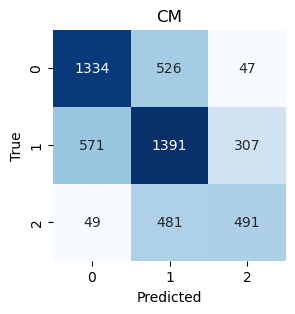

In [17]:
# Without OS, Without feature selection
best_model_3l, best_score_3l, training_time_3l, best_params_3l = tune_MLP(X_train, 
                                                                  y_train, 
                                                                  3)

model_names.append('best_model_3l')
models.append(best_model_3l)
accs.append(best_score_3l)
training_times.append(training_time_3l)
best_params.append(best_params_3l)

Best Parameters: {'solver': 'sgd', 'momentum': 0.9735982417949322, 'learning_rate_init': 0.024401010290662214, 'hidden_layer_sizes': (56, 70, 59), 'alpha': 0.001, 'activation': 'tanh'}
Best Acc Score: 0.6622
Training time: 33.8389

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.67      0.67      1907
           1       0.57      0.51      0.54      2269
           2       0.73      0.81      0.77      2269

    accuracy                           0.66      6445
   macro avg       0.66      0.66      0.66      6445
weighted avg       0.66      0.66      0.66      6445



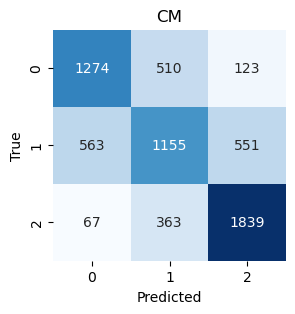

In [18]:
# With OS, Without feature selection
best_model_3l_OS, best_score_3l_OS, training_time_3l_OS, best_params_3l_OS = tune_MLP(X_train_os, 
                                                                                      y_train_os, 
                                                                                      3)

model_names.append('best_model_3l_OS')
models.append(best_model_3l_OS)
accs.append(best_score_3l_OS)
training_times.append(training_time_3l_OS)
best_params.append(best_params_3l_OS)

Best Parameters: {'solver': 'sgd', 'momentum': 0.9649323029998674, 'learning_rate_init': 0.04719709322791683, 'hidden_layer_sizes': (56, 70, 59), 'alpha': 0.0001, 'activation': 'relu'}
Best Acc Score: 0.6237
Training time: 28.1180

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.68      0.67      1907
           1       0.52      0.42      0.47      2269
           2       0.67      0.78      0.72      2269

    accuracy                           0.62      6445
   macro avg       0.62      0.63      0.62      6445
weighted avg       0.61      0.62      0.62      6445



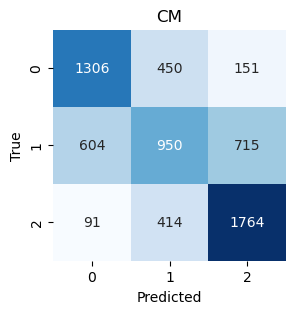

In [19]:
# With OS, With feature selection
best_model_3l_OS_sub, best_score_3l_OS_sub, training_time_3l_OS_sub, best_params_3l_OS_sub = tune_MLP(X_train_os_sub, 
                                                                                      y_train_os_sub, 
                                                                                      3)

model_names.append('best_model_3l_OS_sub')
models.append(best_model_3l_OS_sub)
accs.append(best_score_3l_OS_sub)
training_times.append(training_time_3l_OS_sub)
best_params.append(best_params_3l_OS_sub)

## 3.4. Compare models

In [50]:
# Parse params dictionary into separate lists
solver_list = []
momentum_list = []
learning_rate_init_list = []
hidden_layer_sizes_list = []
alpha_list = []
activation_list = []

for params in best_params:
    solver_list.append(params['solver'])
    momentum_list.append(params['momentum'])
    learning_rate_init_list.append(params['learning_rate_init'])
    hidden_layer_sizes_list.append(params['hidden_layer_sizes'])
    alpha_list.append(params['alpha'])
    activation_list.append(params['activation'])

# Convert lists into df
model_summary = pd.DataFrame({
    'Model Name': model_names,
    'Model': models,
    'Acc_Val': accs,
    'Training Time': training_times,
    'Solver': solver_list,
    'Momentum': momentum_list,
    'Learning Rate Init': learning_rate_init_list,
    'Hidden Layer Sizes': hidden_layer_sizes_list,
    'Alpha': alpha_list,
    'Activation': activation_list
})

# Save results to csv
model_summary.to_csv("model_summary_MLP.csv", index=False)

## 3.5. Decide best model and save model

In [42]:
# Exactact the best final model
best_index = model_summary['Acc_Val'].idxmax()
best_model_final = model_summary['Model'][best_index]

In [43]:
# Fit the best model on training set again and calculate training time
t0 = time.time()
best_model_final.fit(X_train_os, y_train_os)
t1 = time.time()
training_time = t1 - t0

In [48]:
# Save best MLP model
dump(best_model_final, 'best_MLP_v2.joblib')

# # Previous best model
# dump(best_model_final, 'best_MLP.joblib')

['best_MLP_v2.joblib']

## 4. Test on test set

Classification Report on Test Set
              precision    recall  f1-score   support

           0       0.74      0.61      0.67       477
           1       0.63      0.56      0.59       567
           2       0.49      0.77      0.59       256

    accuracy                           0.62      1300
   macro avg       0.62      0.64      0.62      1300
weighted avg       0.64      0.62      0.62      1300



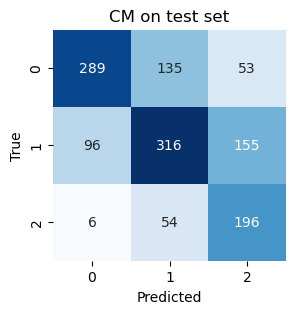

In [51]:
final_test('unseen.csv', 'best_MLP.joblib')